In [1]:
import torch
import gpytorch
import numpy as np
from scipy.stats import norm
from scipy.spatial import distance

import matplotlib
import matplotlib.pyplot as plt

from gpytorch.priors import NormalPrior

from tqdm.notebook import tqdm

# Full Shape Sampling

## Sampling Function

In [12]:
def create_samples(circle_center_x, rec_long_side, rec_short_side, points_per_unit=100):
    diff_x = circle_center_x - (rec_long_side/2)
    assert diff_x > 0
    
    circle_radius = distance.euclidean([circle_center_x,0], [rec_long_side/2,rec_short_side/2])
    
    angle = np.arccos((circle_center_x - rec_long_side/2.0)/circle_radius)
    add_angle = 1/(points_per_unit*circle_radius)
    circle_perimeter = 4 * (np.pi - angle) * circle_radius
    rec_perimeter = 2 * rec_long_side
    total_perimeter = circle_perimeter + rec_perimeter
    
    dumbbell_samples = torch.empty((int(points_per_unit * total_perimeter), 2), dtype=torch.float32)
    samples_till_now = 0
    rec_sample = int(rec_perimeter * points_per_unit/2)
    circle_sample = int(circle_perimeter * points_per_unit/2)
    
    for i in range(rec_sample):
        dumbbell_samples[i] = torch.Tensor([-rec_long_side/2 + i/points_per_unit, rec_short_side/2])
    samples_till_now+=rec_sample
    
    starting_angle = np.pi - angle
    for j in range(circle_sample):
        new_angle = starting_angle - j*add_angle
        dumbbell_samples[samples_till_now+j] = torch.Tensor([circle_center_x+circle_radius*np.cos(new_angle), circle_radius*np.sin(new_angle)])
    samples_till_now+=circle_sample
    
    for i in range(rec_sample):
        dumbbell_samples[samples_till_now+i] = torch.Tensor([rec_long_side/2 - i/points_per_unit, -rec_short_side/2])
    samples_till_now+=rec_sample
    
    starting_angle = angle
    for j in range(circle_sample):
        new_angle = starting_angle + j*add_angle
        dumbbell_samples[samples_till_now+j] = torch.Tensor([-circle_center_x+circle_radius*np.cos(new_angle), circle_radius*np.sin(new_angle)])
    samples_till_now+=circle_sample
    
    full_circles_perimeter = 4 * np.pi * circle_radius
    eye_samples = torch.empty((int(points_per_unit * full_circles_perimeter), 2), dtype=torch.float32)
    
    full_circle_sample = int(full_circles_perimeter * points_per_unit/2)
    
    for i in range(full_circle_sample):
        eye_samples[i] = torch.Tensor([-circle_center_x+circle_radius*np.cos(i*add_angle), circle_radius*np.sin(i*add_angle)])
        eye_samples[full_circle_sample+i] = torch.Tensor([circle_center_x+circle_radius*np.cos(i*add_angle), circle_radius*np.sin(i*add_angle)])
    
    return dumbbell_samples[0:samples_till_now], eye_samples, circle_radius


## Creating Grid

In [3]:
def create_grid(sampled, eps=0.1, res=0.01):
    dims = len(sampled.shape)
    
    borders = torch.empty((dims, 2), dtype=torch.float32)
    for i in range(dims):
        borders[i, 0] = min(sampled[:,i]) - eps
        borders[i, 1] = max(sampled[:,i]) + eps
        
    grid_sizes = torch.empty(dims, dtype=torch.int32)
    for i in range(dims):
        grid_sizes[i] = (borders[i, 1] - borders[i, 0])/res + 1
        
    grid_points = torch.empty((torch.prod(grid_sizes).int(), 2), dtype=torch.float32)
    if (dims==2):
        for x in range(grid_sizes[0]):
            for y in range(grid_sizes[1]):
                index = (x * grid_sizes[1]) + y
                grid_points[index] = torch.Tensor([borders[0, 0] + x * res, borders[1, 0] + y * res])
    return grid_points, grid_sizes

## Computing Unsigned Distance

In [16]:
def distance_from_circle(circle_center, circle_radius, pt):
    return distance.euclidean(pt, circle_center)-circle_radius
    
def udf_dumbbell_pt(circle_center_x, rec_long_side, rec_short_side, circle_radius, pt):
    diff_x = circle_center_x - (rec_long_side/2)
    assert diff_x > 0
    
    circle_center = np.array([circle_center_x, 0])
    x, y = pt

    if -rec_long_side/2 <= x <= rec_long_side/2:
        if -rec_short_side/2 <= y <= rec_short_side/2:
            return min(torch.abs(rec_short_side/2 -y), torch.abs(y+rec_short_side/2))
        else:
            if x < 0:
                circle_center = -circle_center
            if y >= rec_short_side/2:
                return min(y-rec_short_side/2, distance_from_circle(circle_center, circle_radius, pt))
            else:
                return min(-y-rec_short_side/2, distance_from_circle(circle_center, circle_radius, pt))    
    else:
        if x < 0:
                circle_center = -circle_center
        return np.abs(distance_from_circle(circle_center, circle_radius, pt))

def udfs_from_dumbbell(circle_center_x, rec_long_side, rec_short_side, circle_radius, points):
    udf_pts = torch.empty(points.size()[0], dtype=torch.float32)
    for i in range(udf_pts.size()[0]):
        udf_pts[i] = udf_dumbbell_pt(circle_center_x, rec_long_side, rec_short_side, circle_radius, points[i])
    return udf_pts

def udfs_from_eye(circle_center_x, circle_radius, points):
    udf_pts = torch.empty(points.size()[0], dtype=torch.float32)
    rc = np.array([circle_center_x, 0])
    lc = -rc
    for i in range(udf_pts.size()[0]):
        udf_pts[i] = min(np.abs(distance_from_circle(lc, circle_radius, points[i])), np.abs(distance_from_circle(rc, circle_radius, points[i])))
    return udf_pts
    

## Plotting

In [7]:
def get_sample_plot(samples):
    with torch.no_grad():
        fig = plt.figure(figsize=(11, 4))
        ax = fig.add_subplot(111)
        plot = ax.scatter(samples.cpu().numpy()[:, 0], samples.cpu().numpy()[:, 1], s = 0.1)
        ax.axis('equal')
        ax.set_title(f'Samples on the Surface')
        
def get_udf_plot(grid_points, udfs_grid):
    with torch.no_grad():
        fig = plt.figure(figsize=(11, 4))
        ax = fig.add_subplot(111)
        plot = ax.scatter(grid_points.cpu().numpy()[:, 0], grid_points.cpu().numpy()[:, 1], c=udfs_grid.cpu().numpy(),s = 0.1)
        fig.colorbar(plot)
        ax.axis('equal')
        ax.legend_ = None
        ax.set_title(f'Grid Points with UDF')
        
def get_plots(samples, grid_points, udf, plot_samples=True, plot_udf=True):
    if plot_samples:
        get_sample_plot(samples)
    if plot_udf:
        get_udf_plot(grid_points, udf)
        

In [18]:
def initiate_shapes(circle_center_x, rec_long_side, rec_short_side, points_per_unit, plot_samples=True, plot_udf=True):
    dumbbell_samples, eye_samples, circle_radius = create_samples(circle_center_x, rec_long_side, rec_short_side, points_per_unit)
    grid_points, grid_sizes = create_grid(dumbbell_samples)
    grid_udfs_dumbbell = udfs_from_dumbbell(circle_center_x, rec_long_side, rec_short_side, circle_radius, grid_points)
    grid_udfs_eye = udfs_from_eye(circle_center_x, circle_radius, grid_points)
    get_plots(dumbbell_samples, grid_points, grid_udfs_dumbbell, plot_samples, plot_udf)
    get_plots(eye_samples, grid_points, grid_udfs_eye, plot_samples, plot_udf)
    
    return dumbbell_samples, eye_samples, grid_points, grid_udfs_dumbbell, grid_udfs_eye, grid_sizes
    

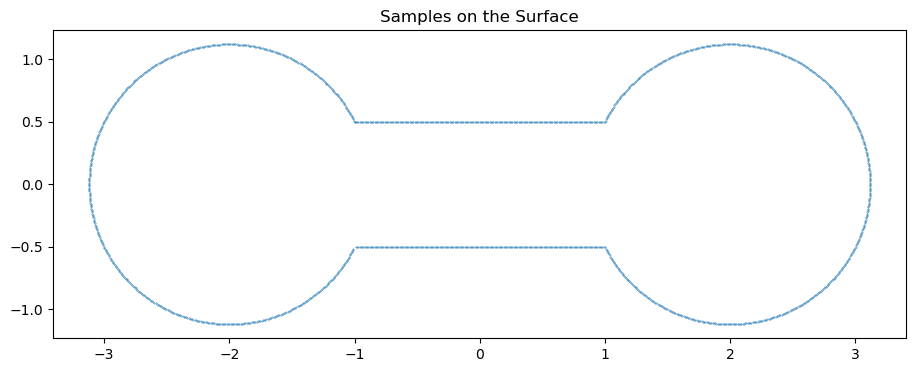

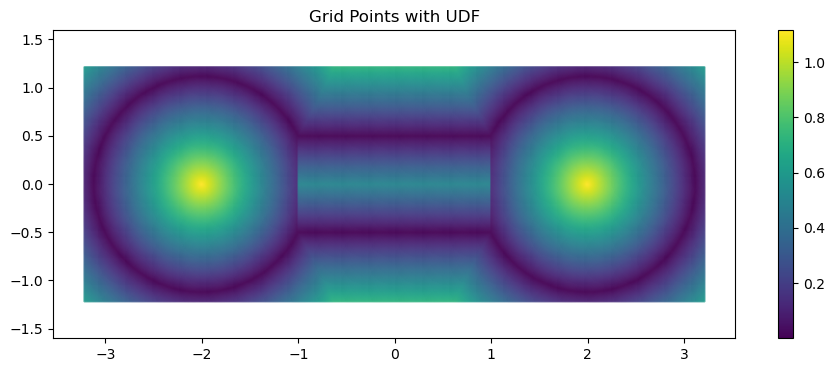

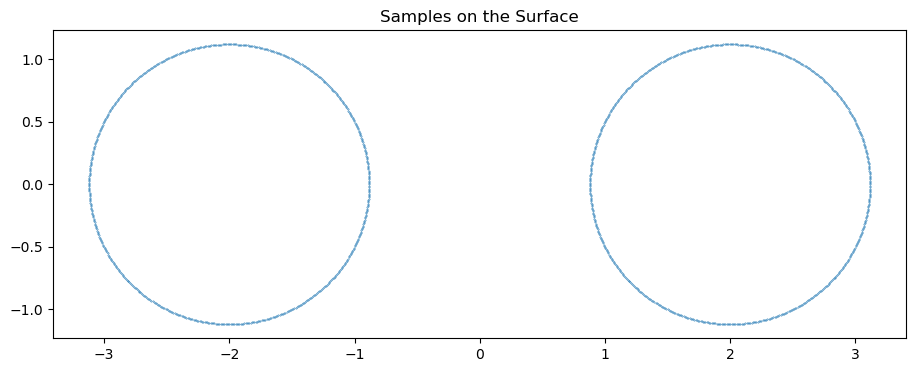

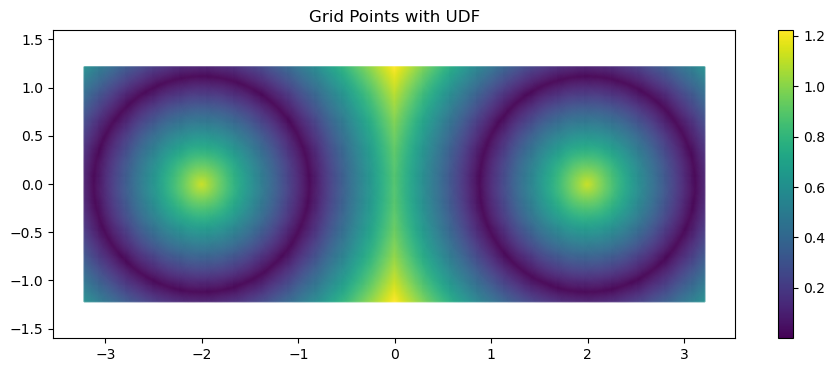

In [19]:
# one example
cr, rl, rs = 2.0, 2.0, 1.0
ds, es, gp, gdd, gde, gs = initiate_shapes(cr, rl, rs, 100)

# Subsampling Circular Parts

In [26]:
def subsample_eye(eye_samples, percent_to_keep):
    full_sample_size = eye_samples.size(0)
    half_sample_size = full_sample_size/2
    throw = (100.0 - percent_to_keep)/100.0
    half_throw = half_sample_size*throw/2
    half_keep = half_sample_size*percent_to_keep/200.0
    subsample_indices_l = np.arange(half_throw, half_sample_size-half_throw, 1)
    subsample_indices_r = np.concatenate((half_sample_size + np.arange(half_keep), np.arange(full_sample_size-half_keep, full_sample_size, 1)))
    subsample_indices = np.concatenate((subsample_indices_l, subsample_indices_r))
    
    return eye_samples[subsample_indices]
    

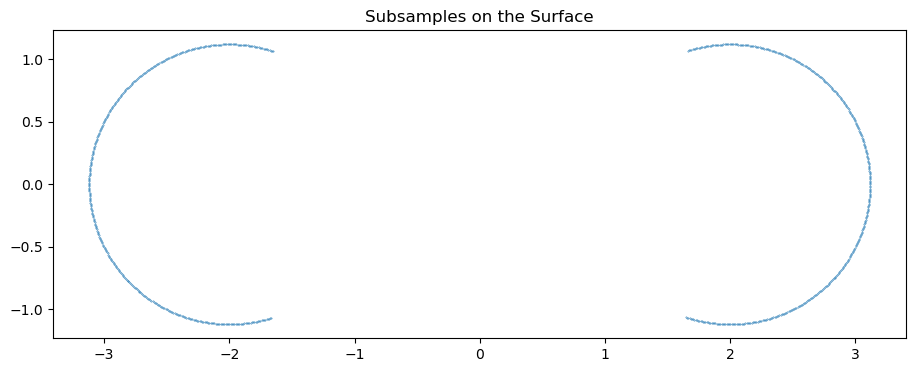

In [27]:
# example
ess = subsample_eye(es, 60)
with torch.no_grad():
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(ess.cpu().numpy()[:, 0], ess.cpu().numpy()[:, 1], s = 0.1)
    ax.axis('equal')
    ax.set_title(f'Subsamples on the Surface')

# Building the Network